# Load Insights Data

In [1]:
import collections

from datetime import datetime
import functools

from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from IPython.core.display import display, HTML
from IPython.display import clear_output

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

import pickle as pkl

import plotly
import plotly.graph_objs as go

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import Row
from pyspark.sql.functions import udf

import re
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import seaborn as sns
import sys
import time

spark = SparkSession.builder \
        .master("local") \
        .config("spark.executor.memory", '16g') \
        .config("spark.driver.memory", '16g') \
        .config("spark.driver.maxResultSize","2g")\
        .getOrCreate()

In [2]:
df=spark.read.parquet("2018-08-09-joined")
schema_names=[i.name for i in df.schema]

In [3]:
display(HTML("<style>.container { width:100% !important; }</style>"))
np.set_printoptions(linewidth=150)
pd.set_option('display.max_columns', 50)

In [4]:
def stop():
    raise Exception("Stopping")

Exception: Stopping

# Column Decompression Helpers

In [5]:
def extract_prefix(string):
    if 'collect_list' in string:
        return string.split("collect_list(")[1].split(")")[0]
    else:
        return string

def java_typer(item):
    if item in ['true','false']:
        return item=='true'
    elif item.isdigit():
        return int(item)
    else:
        return item
    
def java_data_parser(jdate):
    jdate=jdate.replace('java.util.GregorianCalendar[',"")[:-1]
    jdate=jdate.split(",")
    jdate = dict((pair[0],java_typer(pair[1])) for pair in [j.split("=") for j in jdate])
    date = datetime(jdate['YEAR'],jdate['MONTH']+1,jdate['DAY_OF_MONTH'],jdate['HOUR'],jdate['MINUTE'],jdate['SECOND'])
    return date

def java_array_parser(string):
    if string==None:
        return None
    elif all([x in string for x in "[,]"]):
        string=string[1:-1].split(",")
    return string
    
def row_unpack(row):
    d = row.asDict() if type(row)==pyspark.sql.types.Row else row
    out = {}
    for k,v in d.items():
        if type(v) is dict:
            out.update(row_unpack(v))
        else:
            new_k = extract_prefix(k)
            new_v=java_data_parser(v) if new_k=='upload_time' else java_array_parser(v)
            out[new_k]=new_v
    return out

# Column Decompression

In [6]:
def get_column_DF(column,n=5,extract=None):
    if extract is not None:
        out = df.select(column).where(df[column].isNotNull()).take(extract+1)[extract]
    else:
        sample=df.select(column).where(df[column].isNotNull()).take(n)
        out=pd.DataFrame.from_records([row_unpack(x) for x in sample])
        out['n_entries']=out.applymap(lambda x: len(x) if type(x) is list else 1).apply(max,axis=1)
        out['data_source']=column
    return out

col_dfs = [get_column_DF(name,n=1000) for name in schema_names]

# Row Decompression

In [7]:
def split_entries(row):
    values = dict(row)
    out = []
    n=row['n_entries']
    for k,v in values.items():
        if type(v) is not list:
            out.append([v]*n)
        else:
            out.append(v)
    out = pd.DataFrame(list(zip(*out)))
    out.columns = values.keys()
    return out

# Row Vectorizer

In [133]:
def digit_parse(digit,check=False):
    if check:
        if digit == '[]':
            return True
        try:
            float(digit.replace("+",""))
            return True
        except:
            return str(digit).strip().replace('.','',1).replace('[','',1).replace(']','',1).isdigit()
    else:
        if digit == '[]':
            return np.nan
        try:
            return float(digit.replace("+",""))
        except:
            return float(str(digit).strip().replace('[','',1).replace(']','',1))
    
def digitize(digit):
    if digit_parse(digit,check=True):
        return digit_parse(digit)
    else:
        return digit
    
def type_column(col):
    if all([digit_parse(x,check=True) for x in col]):
        out = np.array([digit_parse(x) for x in col])
        nans = np.where(np.isnan(out))
        out[nans] = np.nanmean(out)
        return out  
    elif type(col.iloc[0]) is pd._libs.tslibs.timestamps.Timestamp:
        return [x.timestamp() for x in col]
    elif len(col.iloc[0]) in [32,36] and len([l for l in col.iloc[0] if l in "0123456789abcdef"])==32:
        return [int("0x"+x.replace("-",""),0) for x in col]
    elif any(["telemetry_rules_plugins" in x for x in col]):
        return [x.replace("telemetry_rules_plugins","").strip() for x in col]
    else:
        return [x.strip() for x in col]
    
def vectorize_row(row):
    numerics,cats = [],[]
    for i in row:
        if type(i) is float or type(i) is int:
            numerics.append(i)
        else:
            cats.append(i)
    return [np.array(numerics),cats]

def scaler(X):
    col_mean = np.mean(X,0)
    col_std  = np.std(X,0)
    for i,val in enumerate(col_std):
        if not val:
            col_std[i]=1
    normal = (X-col_mean)/(col_std)
    return normal

# D2V Model

In [9]:
def modelMetrics(model,df):
    most_similar=model.docvecs.most_similar([model.infer_vector(df[0],steps=100,alpha=.025)])
    print("Item 0:",df[0])
    for idx,val in most_similar[:3]:
        print(val,":",df[idx])
        
def Doc2Vec_Modeller(cat_train,d2v_epochs,verbose):
    if verbose: print("Training Doc2Vec...")
    documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(cat_train)]
    model = Doc2Vec(dm=0,vector_size=100, window=5, min_count=0,alpha=0.025, min_alpha=0.025,workers=4,batch_words=250)
    model.build_vocab(documents)        

    for i in range(d2v_epochs):
        if verbose: print("=== Epoch",i,"===")
        model.train(documents,total_examples=model.corpus_count,epochs=model.epochs)
        model.alpha -= 0.002 # decrease the learning rate
        model.min_alpha = model.alpha # fix the learning rate, no decay
        model.train(documents,total_examples=model.corpus_count,epochs=model.epochs)
        if verbose: modelMetrics(model,cat_train)
    return model

# Data Preprocessing, Vectorization

In [61]:
ignored_columns =  ['n_entries','data_source','upload_time','account','system_id','created','image_id','digest']

def process(idx,d2v_epochs=5,samples=10000,verbose=False):
    #select certain column for dfs
    decomp_col=col_dfs[idx]
    title = decomp_col.iloc[0]['data_source']
    print("Vectorizing {}...".format(title))
    if verbose: print("Inspecting",title)
    if verbose: print(len(decomp_col))
    
    #decompress column
    decompressed=pd.concat([split_entries(row) for _,row in decomp_col.iterrows()])
    
    if len(decompressed)>samples:
        if verbose: print("Restricting sample size to",samples)
        decompressed=decompressed.sample(samples)
    
    #extract original data fields
    col_typed = decompressed[[x for x in list(decompressed) if x not in ignored_columns]].apply(type_column,axis=0)
    #print(col_typed.dtypes)
    
    #split df into numeric and categoric data
    numerics,cats=zip(*[vectorize_row(row) for _,row in col_typed.iterrows()])
    numerics = np.vstack(numerics)

    #split into test/train sets
    num_train,num_test,cat_train,cat_test,orig_train,orig_test=train_test_split(numerics,cats,col_typed,train_size=.75,test_size=.25)
    
    #create data names for plotting later
    names_train = ["<br>".join(['{}: {}'.format(k,v) for (k,v) in row]) for row in [d.items() for d in orig_train.to_dict("records")]]
    
    if verbose: 
        print("Train set size:",len(cat_train))
        
    #vectorize categorical fields via D2V
    d2v_model = Doc2Vec_Modeller(cat_train,d2v_epochs,verbose)
    cat_vects_train = np.array([d2v_model.infer_vector(d,steps=100,alpha=0.025) for d in cat_train])
    cat_vects_test  = np.array([d2v_model.infer_vector(d,steps=100,alpha=0.025) for d in cat_test])

    #normalize numeric fields
    if len(num_train.shape)>1 and num_train.shape[1]:       
        num_train_scale = scaler(num_train)
        num_test_scale  = scaler(num_test)

        #join vectors 
        train = np.concatenate([num_train_scale, cat_vects_train],1)
        test  = np.concatenate([num_test_scale,  cat_vects_test ],1)
    else:
        train = cat_vects_train
        test  = cat_vects_test

    return train,names_train,title,d2v_model
 

# Embedding Functions

In [11]:
def embed(train,title):
    print("Clustering {}...".format(title))
    print(len(train))
    umap_model = umap.UMAP(n_neighbors=int(len(train)/100)).fit(train)
    return umap_model.transform(train),umap_model

# Cluster Plotter

In [12]:
from sklearn.cluster import DBSCAN

def plot_clusters(X,title,**kwargs):
    cluster_model = DBSCAN(eps=kwargs.get('eps',.5),min_samples=kwargs.get('min_samples',5)).fit(X)
    labels = cluster_model.labels_

    # assign points into clusters
    unique_labels = set(labels)
    print("Estimated clusters:",len(unique_labels))
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

    label_dict = dict([(i,[]) for i in sorted(unique_labels)])
    for i,pair in enumerate(X):  
        label_dict[labels[i]].append(pair)

    # plot points     
    fig = plt.figure(figsize=(10,5))
    ax = plt.subplot(111)
    for i,(cluster,pairs) in enumerate(label_dict.items()):
        color = [0,0,0,1] if  cluster==-1 else colors[cluster]
        x,y = zip(*pairs)
        ax.scatter(x,y,
                   c=[color]*len(x),
                   label=cluster)
    
    # add legend
    box = ax.get_position()
    ax.set_position([box.x0,box.y0,box.width*.8,box.height])
    ncol = int(np.ceil(len(unique_labels)/20))
    ax.legend(loc='center left',bbox_to_anchor=(1,.5),ncol=ncol)
    
    # display plot
    plt.title(title)
    plt.xlabel("PC0")
    plt.ylabel("PC1")
    plt.show()
    return labels

def cluster_viz(clusters,names_train,to_display='All'):
    #create dataframe of clusters/names
    cluster_df = pd.DataFrame(list(zip(names_train,clusters)),columns=["name","cluster"])
    cluster_sizes = cluster_df['cluster'].value_counts()
    cluster_df['size']=cluster_df['cluster'].apply(lambda x: cluster_sizes[x])
    name_df = pd.DataFrame([dict([subfield.split(": ",1) for subfield in name.split("<br>")]) for name in names_train])
    cluster_sample = cluster_df.groupby("cluster").apply(lambda x: x.sample(min(5,len(x))))

    #group clusters for visualization
    cluster_dict = {}
    for idx,(name,cluster,size) in cluster_sample.iterrows():
        if cluster_dict.get(cluster) is None:
            cluster_dict[cluster]= {'size':size,'members':[idx[1]]}
        else:
            cluster_dict[cluster]['members'].append(idx[1])
    
    #visualize clusters
    for cluster,cluster_details in cluster_dict.items():
        if to_display is 'All' or cluster in to_display:
            print("=== Cluster {}: {} items ===".format(cluster,cluster_details['size']))
            print(cluster_details['members'])
            display(name_df.iloc[cluster_details['members']])

# Principal Component Visualization

In [35]:
def pc_viz(X,names_train,k=3):
    name_df = pd.DataFrame([dict([subfield.split(": ",1) for subfield in name.split("<br>")]) for name in names_train])
    name_df = name_df.applymap(digitize)
    
    name_df['PC0']=X[:,0]
    name_df['PC1']=X[:,1]
    
    pc0 = list(np.argsort(-X[:,0])[:k]) + [np.argsort(X[:,0])[len(X[:,0])//2]] + list(np.argsort(X[:,0])[:k])
    pc1 = list(np.argsort(-X[:,1])[:k]) + [np.argsort(X[:,1])[len(X[:,1])//2]] + list(np.argsort(X[:,1])[:k])

    cm = sns.light_palette("green", as_cmap=True)
    extreme = name_df.iloc[pc0]
    extreme = extreme.style.background_gradient(cmap=cm)
    display(extreme)
    
    extreme = name_df.iloc[pc1]
    extreme = extreme.style.background_gradient(cmap=cm)
    display(extreme)

In [216]:
print(list(enumerate(schema_names)))

[(0, 'identity'), (1, 'insights_parsers_uname_uname'), (2, 'insights_parsers_hostname_hostname'), (3, 'rule_data'), (4, 'insights_parsers_ps_psauxcww'), (5, 'insights_parsers_redhat_release_redhatrelease'), (6, 'insights_parsers_meminfo_meminfo'), (7, 'exec_times'), (8, 'insights_parsers_docker_list_dockerlistimages'), (9, 'insights_combiners_virt_what_virtwhat'), (10, 'insights_parsers_installed_rpms_installedrpms'), (11, 'insights_parsers_dmidecode_dmidecode'), (12, 'insights_parsers_ps_psaux'), (13, 'insights_parsers_cpuinfo_cpuinfo'), (14, 'insights_combiners_services_services'), (15, 'errors'), (16, 'insights_parsers_lsmod_lsmod'), (17, 'insights_parsers_yum_yumrepolist')]


# Exploration

In [15]:
trains,names,titles,embeddings,clusters,pipelines = {},{},{},{},{},{}

In [16]:
targets = [1,2,4,5,6,7,8,9,10,11,12,13,14,15,16,17]

In [134]:
overwrites=[13]
d2v_epochs={10:5}

for target in targets:
    if trains.get(target) is None or target in overwrites:
        trains[target],names[target],titles[target],d2v_model=process(target,d2v_epochs=d2v_epochs.get(target,10))
        embeddings[target],embedder = embed(trains[target],titles[target])
        pipelines[target] = [d2v_model,embedder]

Vectorizing insights_parsers_cpuinfo_cpuinfo...
Clustering insights_parsers_cpuinfo_cpuinfo...
760


/home/campus.ncl.ac.uk/b6070424/.local/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning:

Embedding a total of 4 separate connected components using meta-embedding (experimental)



Estimated clusters: 52


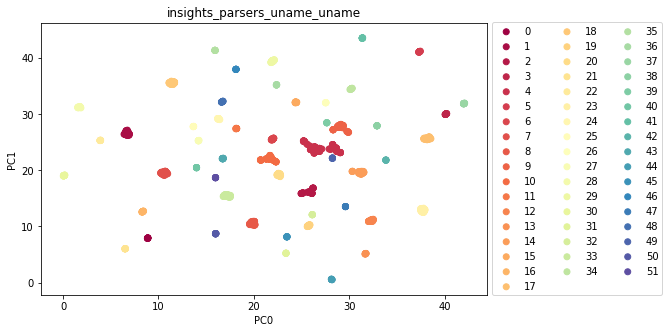

In [37]:
# parsers_uname: clusters by kernel
# PC0 ~ release_major
# PC1: categorical
target = 1
clusters[target] = plot_clusters(embeddings[target],titles[target],eps=1)
#pc_viz(embeddings[target],names[target])
#cluster_viz(clusters[target],names[target])

Samples: 1000
Estimated clusters: 21


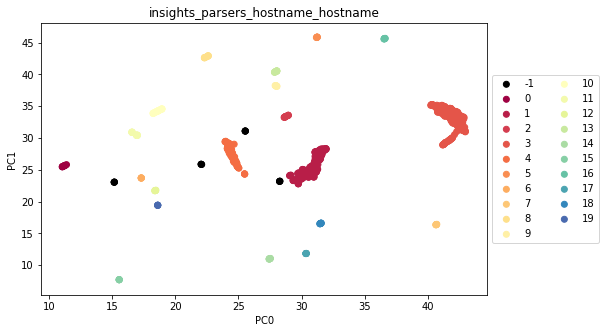

In [88]:
# hostname: clusters by domain
# PC1: categorical
# PC2: categorical
target = 2
print("Samples:",len(col_dfs[target]))
clusters[target] = plot_clusters(embeddings[target],titles[target],eps=1)
#pc_viz(embeddings[target],names[target])
#cluster_viz(clusters[target],names[target])

Samples: 1000
Estimated clusters: 12


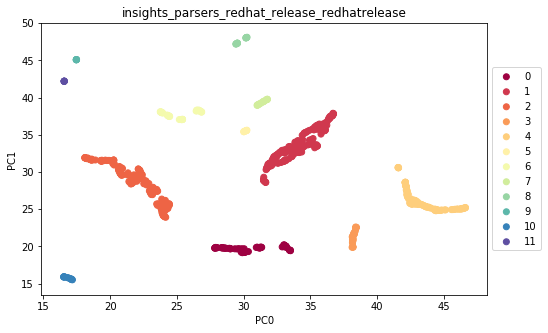

In [89]:
# redhat_release: strongly clusters by is_rhel, major, minor, product, version
#PC1 ~ major + minor release
#PC2 ~ minor release

target = 5
print("Samples:",len(col_dfs[target]))
clusters[target] = plot_clusters(embeddings[target],titles[target],eps=3)
#pc_viz(embeddings[target],names[target])
#cluster_viz(clusters[target],names[target])

Samples: 1000
Estimated clusters: 5


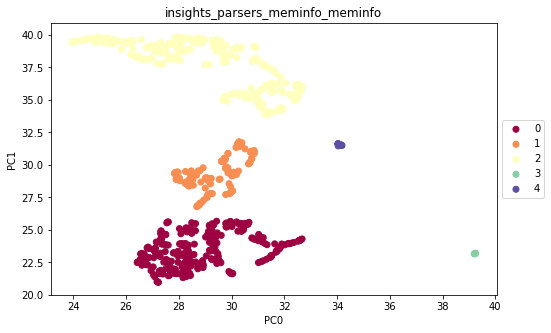

In [90]:
# meminfo: clusters by writeback OR mlocked OR unevictable
# PC0 ~ total memory
# PC1 ~ shmem
target = 6
print("Samples:",len(col_dfs[target]))
clusters[target] = plot_clusters(embeddings[target],titles[target],eps=1)
#pc_viz(embeddings[target],names[target])
#cluster_viz(clusters[target],names[target])

Samples: 1000
Estimated clusters: 473


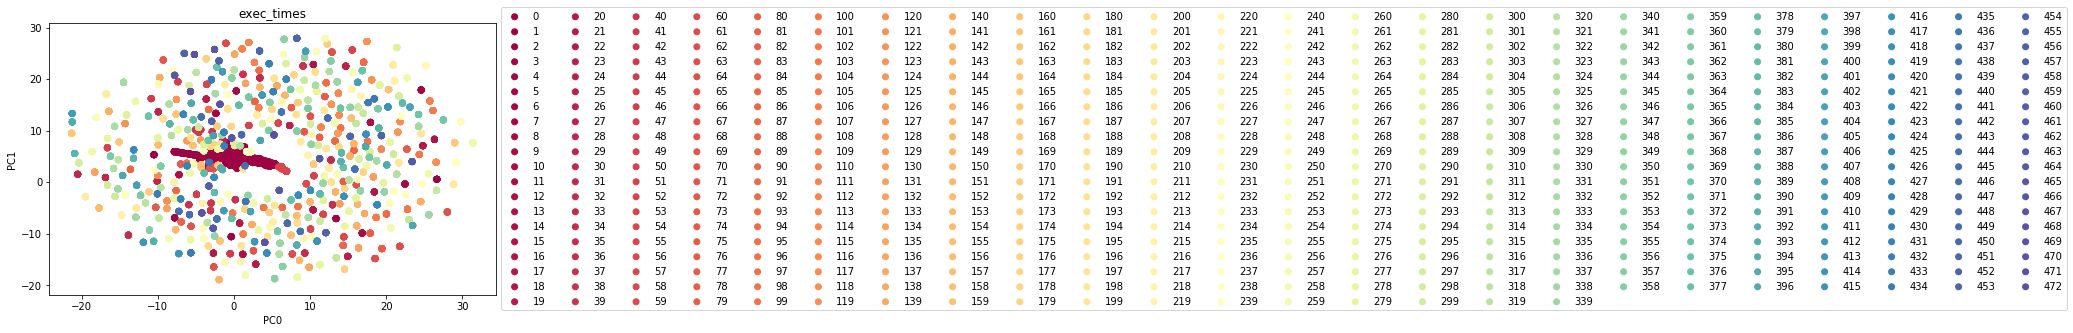

In [91]:
# exec_times: clusters strongly by name
# PC1: categorical
# PC2: categorical

target = 7
print("Samples:",len(col_dfs[target]))
clusters[target] = plot_clusters(embeddings[target],titles[target],eps=.5)
#pc_viz(embeddings[target],names[target])
#cluster_viz(clusters[target],names[target])

Samples: 1000
Estimated clusters: 22


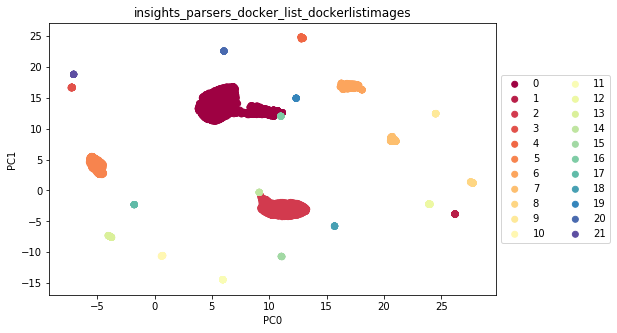

In [92]:
# docker_list: clusters loosely by repository
# PC1 ~ tag
# PC2 ~ repository

target = 8
print("Samples:",len(col_dfs[target]))
clusters[target] = plot_clusters(embeddings[target],titles[target],eps=.5)
#pc_viz(embeddings[target],names[target])
#cluster_viz(clusters[target],names[target])

Samples: 1000
Estimated clusters: 6


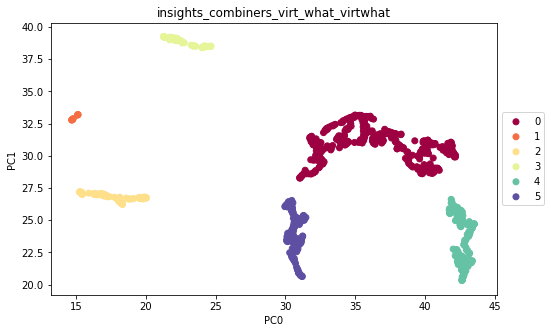

In [93]:
# virt_what: clusters by vm_type
# PC1: categorical
# PC2: categorical

target = 9
print("Samples:",len(col_dfs[target]))
clusters[target] = plot_clusters(embeddings[target],titles[target],eps=1)
#pc_viz(embeddings[target],names[target])
#cluster_viz(clusters[target],names[target])

Samples: 1000
Estimated clusters: 74


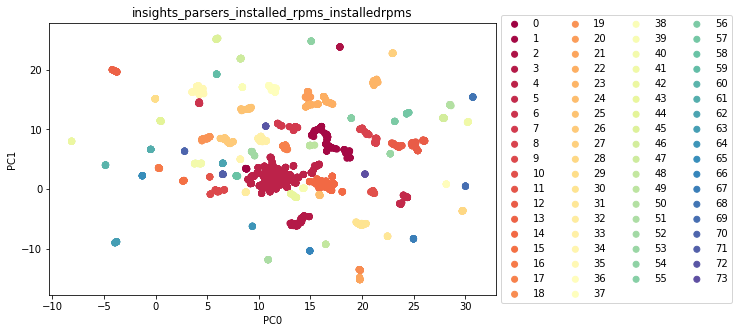

In [94]:
# installed_rpms: clusters by name OR version (maybe this needs tuning?)
# PC1: categorical
# PC2: categorical

target = 10
print("Samples:",len(col_dfs[target]))
clusters[target] = plot_clusters(embeddings[target],titles[target],eps=1)
#pc_viz(embeddings[target],names[target])
#cluster_viz(clusters[target],names[target])

Samples: 1000
Estimated clusters: 9


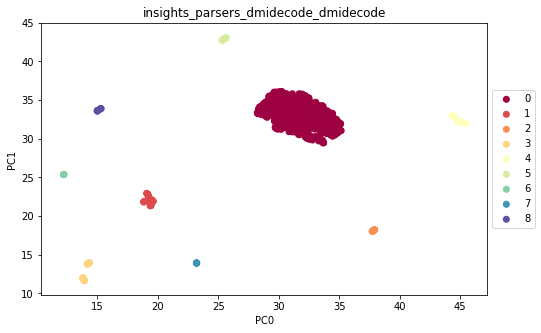

In [95]:
# dmidecode: clusters by bios_vendor, product_name
# PC1: categorical
# PC2: categorical
# ** discovers product families and corrects missing fields!!! **

target = 11
print("Samples:",len(col_dfs[target]))
clusters[target] = plot_clusters(embeddings[target],titles[target],eps=3)
#pc_viz(embeddings[target],names[target])
#cluster_viz(clusters[target],names[target])

Samples: 86
Estimated clusters: 46


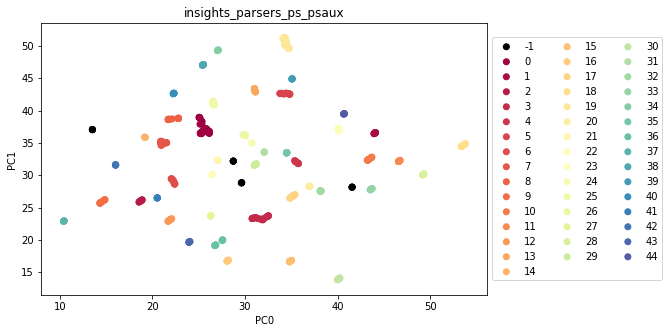

In [98]:
# psaux: clusters by occurence (user AND start AND time and PID) (kinda crap)
# PC1: categorical
# PC2: categorical

target = 12
print("Samples:",len(col_dfs[target]))
clusters[target] = plot_clusters(embeddings[target],titles[target],eps=1)
#pc_viz(embeddings[target],names[target])
#cluster_viz(clusters[target],names[target])

Samples: 1000
Estimated clusters: 44


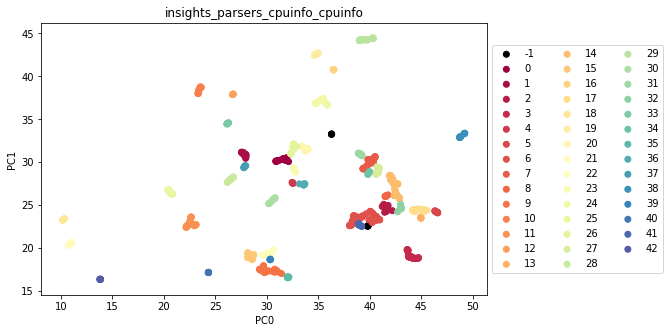

In [140]:
# cpu_info: clusters by model_name (seems to be discovering model families as well)
# PC1 ~ -cache_size + cpu_speed
# PC2 ~ socket_count

target = 13
print("Samples:",len(col_dfs[target]))
clusters[target] = plot_clusters(embeddings[target],titles[target],eps=.5)
#pc_viz(embeddings[target],names[target])
#cluster_viz(clusters[target],names[target])

Samples: 1000
Estimated clusters: 173


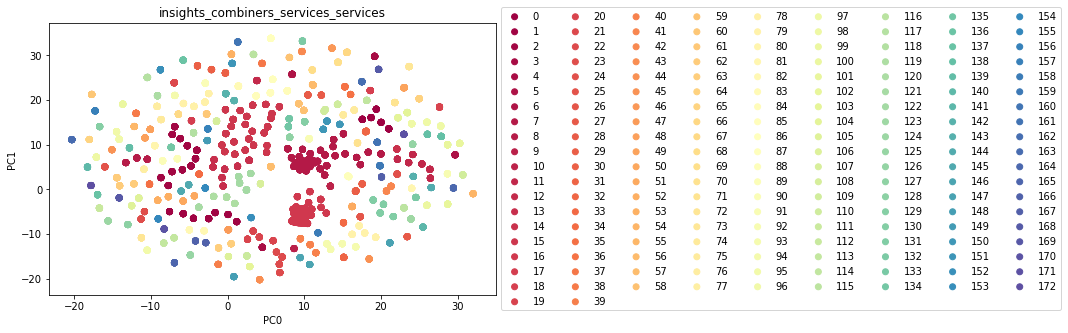

In [142]:
# insights_combiners_services: clusters by name
# PC1: categorical
# PC2: categorical

target = 14
print("Samples:",len(col_dfs[target]))
clusters[target] = plot_clusters(embeddings[target],titles[target],eps=2)
#pc_viz(embeddings[target],names[target])
#cluster_viz(clusters[target],names[target])

Samples: 1000
Estimated clusters: 45


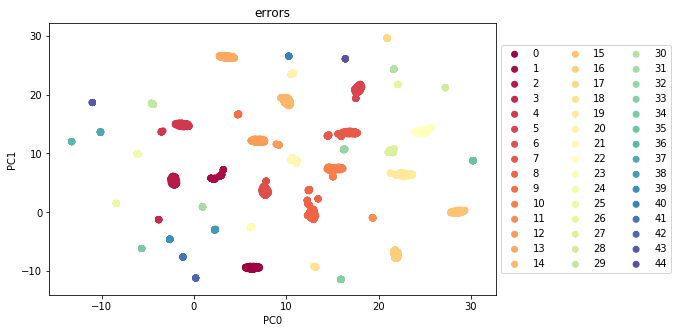

In [145]:
# errors: clusters by name, traceback
# PC1: categorical
# PC2: categorical

target = 15
print("Samples:",len(col_dfs[target]))
clusters[target] = plot_clusters(embeddings[target],titles[target],eps=2)
#pc_viz(embeddings[target],names[target])
#cluster_viz(clusters[target],names[target])

Samples: 1000
Estimated clusters: 69


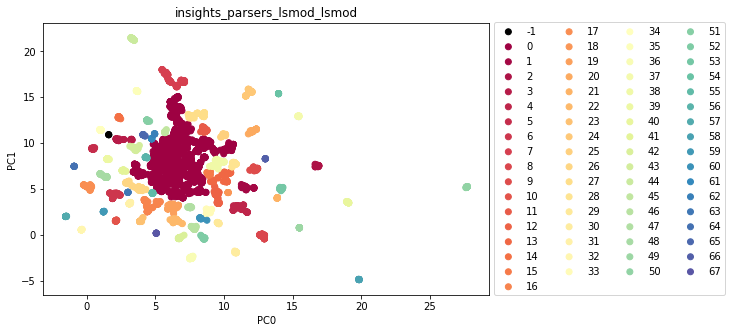

In [149]:
# lsmod: clusters by loosely by name OR deplist
#PC1 ~ depnum, size
#PC2 ~ depnum, size

target = 16
print("Samples:",len(col_dfs[target]))
clusters[target] = plot_clusters(embeddings[target],titles[target],eps=.5)
#pc_viz(embeddings[target],names[target])
#cluster_viz(clusters[target],names[target])

Samples: 1000
Estimated clusters: 108


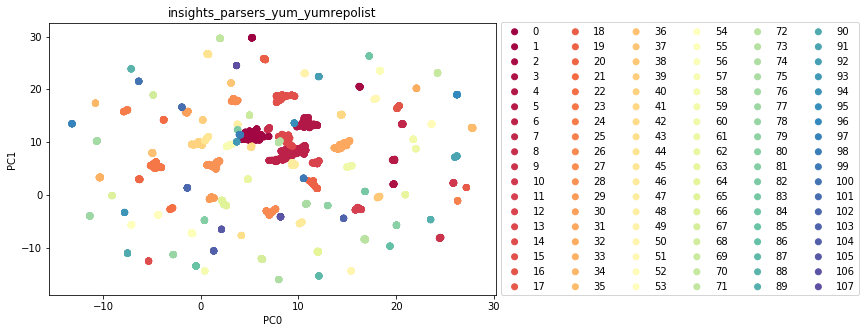

In [153]:
# yumrepolist: clusters loosely by id, name
# PC1: categorical
# PC2: categorical

target = 17
print("Samples:",len(col_dfs[target]))
clusters[target] = plot_clusters(embeddings[target],titles[target],eps=.5)
#pc_viz(embeddings[target],names[target])
#cluster_viz(clusters[target],names[target])